# 27. DCGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 27.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

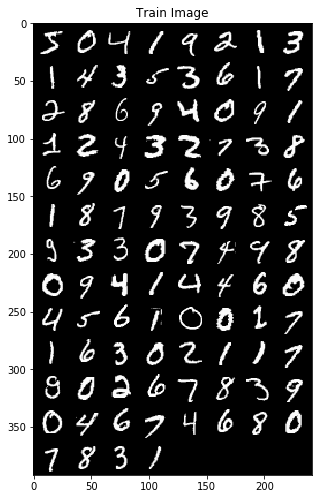

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 27.2 Define Model

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 100, 4, stride=2, padding=1),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(100, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(200, 100, 4, stride=1, padding=0),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(100, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(-1, 1)
        return out

In [8]:
D = Discriminator().cuda()

In [9]:
D(Variable(images).cuda()).shape

torch.Size([100, 1])

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 200, 4, stride=1, padding=0),
            nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(200, 400, 4, stride=1, padding=0),
            nn.BatchNorm2d(400),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(400, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(200, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        out = self.generator(x)
        return out

In [11]:
G = Generator().cuda()

In [12]:
z = Variable(torch.randn((batch_size, 100))).cuda()
G(z).shape

torch.Size([100, 1, 28, 28])

## 27.3 Model Training

In [13]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, Variable(target_tensor).cuda())

In [14]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [15]:
num_epochs = 50

In [16]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images).cuda()
            
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.data[0], G_loss.data[0]))

Epoch [1/50], lter [100/600], D_Loss: 0.6173, G_Loss: 1.3609
Epoch [1/50], lter [200/600], D_Loss: 0.2621, G_Loss: 2.1947
Epoch [1/50], lter [300/600], D_Loss: 0.2656, G_Loss: 2.5926
Epoch [1/50], lter [400/600], D_Loss: 0.0932, G_Loss: 3.1218
Epoch [1/50], lter [500/600], D_Loss: 0.1209, G_Loss: 3.3018
Epoch [1/50], lter [600/600], D_Loss: 0.0407, G_Loss: 4.1630
Epoch [2/50], lter [100/600], D_Loss: 0.0328, G_Loss: 3.9084
Epoch [2/50], lter [200/600], D_Loss: 0.0892, G_Loss: 4.0021
Epoch [2/50], lter [300/600], D_Loss: 0.0519, G_Loss: 4.7398
Epoch [2/50], lter [400/600], D_Loss: 0.0178, G_Loss: 5.7878
Epoch [2/50], lter [500/600], D_Loss: 0.0194, G_Loss: 5.4490
Epoch [2/50], lter [600/600], D_Loss: 0.1381, G_Loss: 7.1178
Epoch [3/50], lter [100/600], D_Loss: 0.0137, G_Loss: 5.7873
Epoch [3/50], lter [200/600], D_Loss: 0.0514, G_Loss: 6.7078
Epoch [3/50], lter [300/600], D_Loss: 0.0290, G_Loss: 5.7051
Epoch [3/50], lter [400/600], D_Loss: 0.0103, G_Loss: 6.8943
Epoch [3/50], lter [500/

Epoch [23/50], lter [300/600], D_Loss: 0.6388, G_Loss: 1.4133
Epoch [23/50], lter [400/600], D_Loss: 0.6179, G_Loss: 1.8580
Epoch [23/50], lter [500/600], D_Loss: 0.6443, G_Loss: 1.7036
Epoch [23/50], lter [600/600], D_Loss: 0.3712, G_Loss: 2.6897
Epoch [24/50], lter [100/600], D_Loss: 0.7031, G_Loss: 1.4509
Epoch [24/50], lter [200/600], D_Loss: 0.8813, G_Loss: 2.1898
Epoch [24/50], lter [300/600], D_Loss: 0.7661, G_Loss: 1.7271
Epoch [24/50], lter [400/600], D_Loss: 0.5388, G_Loss: 2.4451
Epoch [24/50], lter [500/600], D_Loss: 0.8394, G_Loss: 1.4789
Epoch [24/50], lter [600/600], D_Loss: 0.7732, G_Loss: 1.3942
Epoch [25/50], lter [100/600], D_Loss: 0.9871, G_Loss: 1.5702
Epoch [25/50], lter [200/600], D_Loss: 0.6056, G_Loss: 2.5661
Epoch [25/50], lter [300/600], D_Loss: 0.6450, G_Loss: 2.4783
Epoch [25/50], lter [400/600], D_Loss: 0.7599, G_Loss: 2.1673
Epoch [25/50], lter [500/600], D_Loss: 0.7230, G_Loss: 1.6943
Epoch [25/50], lter [600/600], D_Loss: 0.3577, G_Loss: 1.8075
Epoch [2

Epoch [45/50], lter [400/600], D_Loss: 1.0344, G_Loss: 1.5321
Epoch [45/50], lter [500/600], D_Loss: 0.6524, G_Loss: 1.7794
Epoch [45/50], lter [600/600], D_Loss: 0.2862, G_Loss: 1.6328
Epoch [46/50], lter [100/600], D_Loss: 0.8237, G_Loss: 1.8363
Epoch [46/50], lter [200/600], D_Loss: 0.9271, G_Loss: 1.6287
Epoch [46/50], lter [300/600], D_Loss: 0.7472, G_Loss: 1.5178
Epoch [46/50], lter [400/600], D_Loss: 1.0447, G_Loss: 1.5910
Epoch [46/50], lter [500/600], D_Loss: 0.8007, G_Loss: 1.3881
Epoch [46/50], lter [600/600], D_Loss: 0.3848, G_Loss: 1.4078
Epoch [47/50], lter [100/600], D_Loss: 0.9355, G_Loss: 1.4278
Epoch [47/50], lter [200/600], D_Loss: 0.7895, G_Loss: 1.6671
Epoch [47/50], lter [300/600], D_Loss: 0.5860, G_Loss: 1.7445
Epoch [47/50], lter [400/600], D_Loss: 1.0413, G_Loss: 1.2437
Epoch [47/50], lter [500/600], D_Loss: 0.5570, G_Loss: 1.7537
Epoch [47/50], lter [600/600], D_Loss: 0.6122, G_Loss: 1.5926
Epoch [48/50], lter [100/600], D_Loss: 0.9331, G_Loss: 1.4066
Epoch [4

## 27.4 Test Model

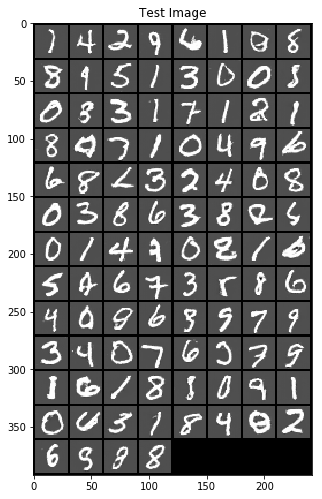

In [17]:
z = Variable(torch.randn((batch_size, 100))).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")